**About:** Entry to the [Natural Language Processing with Disaster Tweets Kaggle Competition](https://www.kaggle.com/competitions/nlp-getting-started), with the best accuracy of 0.81642, ranking 158/810.

**Goal:** To predict whether a tweet is about a real disaster, using RoBERTa (for getting the encodings of a tweet) and Simple Neural Network (for classification). 

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install transformers

     |████████████████████████████████| 4.0 MB 15.8 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
     |████████████████████████████████| 895 kB 65.6 MB/s 
     |████████████████████████████████| 6.5 MB 68.7 MB/s 
     |████████████████████████████████| 596 kB 75.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
import spacy
import re

nlp = spacy.load('en_core_web_sm')

from transformers import RobertaTokenizer, TFRobertaModel

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
 
lemmatizer = WordNetLemmatizer()
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, MaxPooling1D, LeakyReLU, Dropout
from keras.regularizers import l2

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

# Prepare data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Twitter_Kaggle/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
def process_text(string):
    string = string.replace('&amp;', '&')
    string = string.replace('%20', ' ')
    string = string.replace('\n', ' ')
    string = string.replace('&#39;', ' ')
    string = string.replace('ª', ' ')
    string = string.replace('&quot;', ' ')
    string = string.replace('&amp;', ' ')
    string = string.replace('&lt;', '<')
    string = string.replace('&gt;', '>')
    string = string.replace('&', 'and')
    string = string.replace('@', ' mention ')
    string = string.replace('#', ' hashtag ')

    to_remove = ['\x89Û', '\x89ÛÒ', '\x89ã¢', 'Ó', 'Ò', 'å', 'Ê', '\x9d', '¢', '¢', '«']

    for each in to_remove:
      string = string.replace(each, '')

    link_pattern = re.compile(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))")
    
    links = [elem[0] for elem in re.findall(link_pattern, string)]

    for l in links:
        string = string.replace(l, 'link')
    
    for char in ",.!?/\;:()`[]{}|~*=+<>÷ï":
      string = string.replace(char, ' ')

    while '  ' in string:
        string = string.replace('  ', ' ')

    return string.strip()

## Process text, keyword, and location

In [ ]:
text = data['text'].values
texts = [process_text(str(elem)) for elem in text]

keyword = data['keyword'].values
keyword = [process_text(str(elem)) for elem in keyword]

location = data['location'].values
location = [process_text(str(elem)) for elem in location]

## Add the location, keywords, and text together and Tokenize

In [ ]:
data_tokenized = []
for i, s in enumerate(texts):
  full_sentence = []
  
  loc, kw = '', ''
  if location[i] != 'nan':
      loc = [t.text for t in nlp(location[i])]
  full_sentence += loc
  
  if keyword[i] != 'nan':
      kw = [t.text for t in nlp(keyword[i])]
  full_sentence += kw
  
  doc = [token.text for token in nlp(s)]
  full_sentence += doc

  full_sentence_ = []
  for w in full_sentence:
    if '_' in w:
      w_ls = w.split('_')
      full_sentence_ += [lemmatizer.lemmatize(w_.lower()) for w_ in w_ls]
    full_sentence_.append(lemmatizer.lemmatize(w.lower()))

  data_tokenized.append(full_sentence_)

In [ ]:
data_tokenized_str = []
for sentence in data_tokenized:
  sentence_str = ' '.join(sentence)
  while '  ' in sentence_str:
    sentence_str = sentence_str.replace('  ', ' ')
  data_tokenized_str.append(sentence_str)


In [ ]:
data_tokenized_str[:50]

['our deed are the reason of this hashtag earthquake may allah forgive u all',
 'forest fire near la ronge sask canada',
 "all resident asked to ' shelter in place ' are being notified by officer no other evacuation or shelter in place order are expected",
 '13 000 people receive hashtag wildfire evacuation order in california',
 'just got sent this photo from ruby hashtag alaska a smoke from hashtag wildfire pours into a school',
 'hashtag rockyfire update california hwy 20 closed in both direction due to lake county fire - hashtag cafire hashtag wildfire',
 'hashtag flood hashtag disaster heavy rain cause flash flooding of street in manitou colorado spring area',
 "i 'm on top of the hill and i can see a fire in the wood",
 "there 's an emergency evacuation happening now in the building across the street",
 "i 'm afraid that the tornado is coming to our area",
 'three people died from the heat wave so far',
 'haha south tampa is getting flooded hah- wait a second i live in south tamp

In [ ]:
max_length = max([len(s) for s in data_tokenized])

## Get sentence representation using BERT

In [ ]:
def get_inputs(raw_sentence_ls, model, maxlen):

    sentence_rep_ls = []
    
    for sentence in raw_sentence_ls:
    
        sent_tokenized = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, 
                                               padding = 'max_length')
        input_ids = np.reshape(np.array(sent_tokenized['input_ids']), (1,-1))
        mask = np.reshape(np.array(sent_tokenized['attention_mask']), (1,-1))

        output = model(input_ids, attention_mask=mask)

        sentence_rep_ls.append(output.pooler_output)

    return sentence_rep_ls 
    

In [ ]:
bert_model = TFRobertaModel.from_pretrained('roberta-large')

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-large were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
pooler_outputs = get_inputs(data_tokenized_str, bert_model, maxlen = max_length)

In [ ]:
pooler_outputs_arr = np.array(pooler_outputs)
pooler_outputs_arr.shape

(7613, 1, 1024)

## Split data into train and val set

In [ ]:
train_data = np.transpose(pooler_outputs_arr, (0, 2, 1))

In [ ]:
target = data['target'].values
label_one_hot = tf.keras.utils.to_categorical(target, num_classes= 2)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_data, label_one_hot, test_size=0.1, random_state=44)

In [ ]:
X_train.shape

(6851, 1024, 1)

In [ ]:
y_val.shape

(762, 2)

# Model

In [ ]:
inputs_ = tf.keras.layers.Input(shape=(1024,1), name='input_representation', dtype='float32') 
X = Flatten()(inputs_)
X = Dense(1024, activation ='relu')(X)
X = Dropout(0.4)(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.2)(X)
X = Dense(2, activation='sigmoid')(X)
model = tf.keras.Model(inputs=inputs_, outputs = X)

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights= True)

history = model.fit(X_train, y_train, validation_data= (X_val, y_val), batch_size = 1024, epochs = 3000, 
                    callbacks=[early_stop_cb], verbose = 2)

Streaming output truncated to the last 5000 lines.
Epoch 160/3000
7/7 - 0s - loss: 0.6363 - accuracy: 0.6551 - val_loss: 0.6252 - val_accuracy: 0.6549 - 53ms/epoch - 8ms/step
Epoch 161/3000
7/7 - 0s - loss: 0.6363 - accuracy: 0.6637 - val_loss: 0.6243 - val_accuracy: 0.6654 - 52ms/epoch - 7ms/step
Epoch 162/3000
7/7 - 0s - loss: 0.6368 - accuracy: 0.6650 - val_loss: 0.6234 - val_accuracy: 0.6614 - 55ms/epoch - 8ms/step
Epoch 163/3000
7/7 - 0s - loss: 0.6351 - accuracy: 0.6617 - val_loss: 0.6226 - val_accuracy: 0.6995 - 53ms/epoch - 8ms/step
Epoch 164/3000
7/7 - 0s - loss: 0.6332 - accuracy: 0.6609 - val_loss: 0.6217 - val_accuracy: 0.6772 - 53ms/epoch - 8ms/step
Epoch 165/3000
7/7 - 0s - loss: 0.6344 - accuracy: 0.6996 - val_loss: 0.6211 - val_accuracy: 0.6496 - 53ms/epoch - 8ms/step
Epoch 166/3000
7/7 - 0s - loss: 0.6315 - accuracy: 0.6490 - val_loss: 0.6201 - val_accuracy: 0.7139 - 53ms/epoch - 8ms/step
Epoch 167/3000
7/7 - 0s - loss: 0.6308 - accuracy: 0.6996 - val_loss: 0.6193 - va

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_representation (Input  [(None, 1024, 1)]        0         
 Layer)                                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout_73 (Dropout)        (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_74 (Dropout)        (None, 512)               0         
                                                             

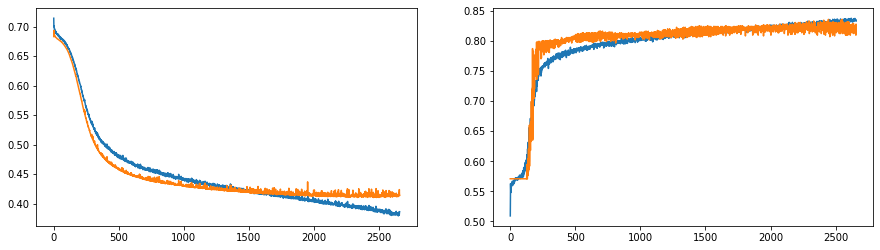

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
plt.show()

# Test model

## Read and process test data

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Twitter_Kaggle/test.csv')
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
ttext = test_data['text'].values
ttext = [process_text(str(elem)) for elem in ttext]

tlocation = test_data['location'].values
tlocation = [process_text(str(elem)) for elem in tlocation]

tkeyword = test_data['keyword'].values
tkeyword = [process_text(str(elem)) for elem in tkeyword]

In [ ]:
ttext[:10]

['Just happened a terrible car crash',
 'Heard about hashtag earthquake is different cities stay safe everyone',
 'there is a forest fire at spot pond geese are fleeing across the street I cannot save them all',
 'Apocalypse lighting hashtag Spokane hashtag wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan',
 "We're shaking It's an earthquake",
 "They'd probably still show more life than Arsenal did yesterday eh EH",
 'Hey How are you',
 'What a nice hat',
 'Fuck off']

In [ ]:
test_data_tokenized = []
for i, s in enumerate(ttext):
    full_sentence = []
    
    loc, kw = '', ''
    if tlocation[i] != 'nan':
      loc = [t.text for t in nlp(tlocation[i])]
    full_sentence += loc
    
    if tkeyword[i] != 'nan':
      kw = [t.text for t in nlp(tkeyword[i])]
    full_sentence += kw

    doc = [token.text for token in nlp(s)]
    full_sentence += doc

    full_sentence_ = []
    for w in full_sentence:
      if '_' in w:
        w_ls = w.split('_')
        full_sentence_ += [lemmatizer.lemmatize(w_.lower()) for w_ in w_ls]
      full_sentence_.append(lemmatizer.lemmatize(w.lower()))

    test_data_tokenized.append(full_sentence_)


In [ ]:
max_length_test = max([len(s) for s in test_data_tokenized])
max_length_test

41

In [ ]:
test_data_tokenized_str = [' '.join(sentence) for sentence in test_data_tokenized]

X_test = get_inputs(test_data_tokenized_str, bert_model, max_length_test)

In [ ]:
X_test_ = np.transpose(np.array(X_test), (0, 2,1))
X_test_.shape

(3263, 1024, 1)

In [ ]:
test_pred_model = np.argmax(model.predict(X_test_), axis = 1)

In [ ]:
test_pred_model[:50]

array([1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0])

## Save into submission file

In [ ]:
sent_id = test_data['id'].values

result = {'id' : sent_id,
          'target' : test_pred_model}

result_df = pd.DataFrame.from_dict(data = result)
result_df.to_csv('result.csv', index = False)